In [ ]:
# pip installs go here

In [ ]:
# imports go here
import os
import pickle
import numpy as np
import librosa
import random
import soundfile as sf
import time
import re
import datetime
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# global variables go here
TIMIT_ROOT = "/content/gdrive/MyDrive/TIMIT/data"
LOGMEL_ROOT = "/content/gdrive/MyDrive/TIMIT/data/logmels/"
CHECKPT_DIR = "/content/gdrive/MyDrive/TIMIT/SV-checkpts"

num_frames = 180                # Number of frames after preprocessing
hop = 0.01                      # Hop length in s
window = 0.025                  # Window size in s
n_fft = 512                     # Length of windowed signal after padding
sr = 16000                      # Sampling rate
win_length = int(window * sr)   # Window length
hop_length = int(hop * sr)      # Hop length
n_mels = 40                     # Number of Mel bands
epsilon = 1e-8                  # Small amount to add to avoid taking log of 0

n_hidden = 768                  # Dimensionality of LSTM outputs
n_projection = 256              # Dimensionality after projection
num_layers = 3                  # Number of LSTM layers
n_speakers = 3                  # Number of speakers per batch
n_utterances_per_speaker = 10   # Number of utterances per speaker each batch

BATCH_SIZE = 16                 # Batch size
NUM_EPOCHS = 10                 # Number of epochs

force_restart_training = False  # Force training to restart from epoch 0
save = True                     # Whether to save model parameters
load_opts = True                # Load optimizer states along with model param values
halve_after_every = 12          # Number of epochs after which to halve learning rate

## Dataset

In [ ]:
def get_spectrograms_for_file(file_path):
  """
  Returns the log mel specrogram's first and last n_frames frames for each "portion". 
  Implementation is based on 
  https://github.com/HarryVolek/PyTorch_Speaker_Verification/blob/master/data_preprocess.py.
  """
  min_length = (num_frames*hop + window)*sr
  # Load the audio
  y, _ = librosa.load(file_path, sr=sr)
  # Split the audio into non-silent intervals. 
  # Reference implementation takes top_db (thresh for silence) to be 30, but librosa
  # default is 60.
  intervals = librosa.effects.split(y, top_db=30)
  extracted = []
  for i in range(intervals.shape[0]):
    begin = intervals[i][0]
    end = intervals[i][1]
    if end - begin <= min_length:
      continue
    # Extract relevant portion of wav
    yp = y[begin:end]
    # Perform STFT
    stft = librosa.stft(y=yp, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
    # Squared magnitude of stft - abs necessary because complex
    sqmag = np.abs(stft) ** 2
    # Get mel basis
    M = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    # Extract log mel spectrogram
    logmel = np.log10(np.dot(M, sqmag) + epsilon)
    # Return the first and last n_frames frames
    extracted.append(logmel[:, :num_frames])
    extracted.append(logmel[:, -num_frames:])
  return extracted

def get_spectrograms_for_speaker(speaker_dir):
  """
  Given a directory with a speaker's utterances, returns the concatenated list
  of extracted log mel features from them *after* converting it into a numpy array.
  """
  extracted = []
  for fname in os.listdir(speaker_dir):
    if fname.endswith(".WAV.wav"):
      extracted += get_spectrograms_for_file(os.path.join(speaker_dir, fname))
  return np.array(extracted)

def save_spectrograms(splits = ["TRAIN", "TEST"]):
  """
  Call only once. Goes through each speaker dir and saves the generated spectrograms
  under LOGMEL_ROOT/{split}
  """
  for split in splits:
    split_data_dir = os.path.join(TIMIT_ROOT, split)
    split_logmel_dir = os.path.join(LOGMEL_ROOT, split)
    for DR in os.listdir(split_data_dir):
      DR_dir = os.path.join(split_data_dir, DR)
      for speaker in os.listdir(DR_dir):
        extracted = get_spectrograms_for_speaker(os.path.join(DR_dir, speaker))
        out_file = os.path.join(split_logmel_dir, "{}.npy".format(speaker))
        np.save(open(out_file, 'wb+'), extracted)

def load_data(splits = ["TRAIN", "TEST"], min_samples=4):
  """
  Loads the dataset -- removes all speakers with < 4 examples.
  """
  data = {}
  for split in splits:
    part = []
    ldir = os.path.join(LOGMEL_ROOT, split)
    for fname in os.listdir(ldir):
      if not fname.endswith(".npy"):
        continue
      narray = np.load(open(os.path.join(ldir, fname), "rb"))
      if narray.shape[0] < min_samples:
        continue
      part.append(narray)
    data[split] = part
  return data

In [ ]:
class SpeakerVerificationDataset(Dataset):
  def __init__(self, logmels, n_speakers=n_speakers, \
    n_samples_per_speaker=n_utterances_per_speaker, total_examples=80000):
    """
    total_examples is the number of examples drawn per epoch
    """
    self.logmels = logmels
    self.n_total_speakers = len(self.logmels)
    self.n_speakers = n_speakers
    self.n_samples_per_speaker = n_samples_per_speaker
    self.total_examples = total_examples

  def __len__(self):
    return self.total_examples

  def __getitem__(self, idx):
    """
    For now we simply ignore idx and return a random sample
    """
    # First, select n different random speakers
    # Use the commented code when number of speakers is more
    # speakers = np.random.permutation(self.n_total_speakers)[:self.n_speakers]
    speakers = []
    while len(speakers) < self.n_speakers:
      speaker = random.randint(0, self.n_total_speakers-1)
      if speaker not in speakers:
        speakers.append(speaker)
    data = []
    for speaker in speakers:
      # We may have as low as 8-10 (up to 28) examples per speaker, and we want to choose
      # 4-10 of them. A permutation likely avoids the otherwise many tries.
      utter_idxs = np.random.permutation(self.logmels[speaker].shape[0])[:self.n_samples_per_speaker]
      utterances = torch.from_numpy(self.logmels[speaker][utter_idxs, :, :])
      data.append(utterances)
    item = torch.stack(data)
    # Currently have (speaker, utterance, mel, frames)
    # Reorder to (speaker, utterance, frames, mel)
    return torch.permute(item, (0,1,3,2))

In [ ]:
data = load_data(min_samples=n_utterances_per_speaker)
train_dataset = SpeakerVerificationDataset(data['TRAIN'])
test_dataset = SpeakerVerificationDataset(data['TEST'], total_examples=8000)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
class SpeakerEmbedder(nn.Module):
  """
  The input to this model is of shape (batch_size*N*M, frames, mel)
  """
  def __init__(self):
    super(SpeakerEmbedder, self).__init__()
    self.LSTMs = nn.LSTM(input_size=n_mels, hidden_size=n_hidden, \
                         num_layers=num_layers, batch_first=True)
    self.FC = nn.Linear(n_hidden, n_projection)

  def forward(self, x):
    LSTMs_out, _ = self.LSTMs(x)
    # Current shape is (batch_size*N*M, n_timesteps, n_hidden)
    # Need only the last time step
    last_out = LSTMs_out[:, LSTMs_out.size(1)-1]
    # Now the shape is (batch_size*N*M, n_hidden)
    FC_out = self.FC(last_out)
    # Normalize each "row"
    FC_out = FC_out / torch.linalg.norm(FC_out, axis=1).unsqueeze(axis=1)
    return FC_out

class LossModule(nn.Module):
  # Values taken from 
  # https://github.com/HarryVolek/PyTorch_Speaker_Verification/blob/master/speech_embedder_net.py
  def __init__(self):
    super(LossModule, self).__init__()
    self.w = nn.Parameter(torch.tensor(10.0), requires_grad=True)
    self.b = nn.Parameter(torch.tensor(-5.0), requires_grad=True)

  def forward(self, embeddings):
    # The input should be in the shape (batch_size, N, M, n_projection)
    # First get the centroids
    centroids = torch.mean(embeddings, dim=2)
    N = embeddings.shape[1]
    M = embeddings.shape[2]
    S = torch.zeros(BATCH_SIZE, N, M, N)
    loss = 0
    # Good old loops, here we come...
    for b in range(BATCH_SIZE):
      for j in range(N):
        for i in range(M):
          for k in range(N):
            if j == k:
              # In this case recompute centroid to not include current example
              centroid = (M*centroids[b,k] - embeddings[b,j,i]) / (M-1)
            else:
              centroid = centroids[b,k]
            S[b,j,i,k] = self.w*torch.dot(embeddings[b,j,i], centroid) + self.b
            if j == k:
              loss -= S[b,j,i,k]
    expsum = torch.sum(torch.exp(S), axis=-1)
    loss += torch.sum(torch.log(expsum))
    return loss

In [ ]:
embedder = SpeakerEmbedder()
lossmodule = LossModule()
embedder_optimizer = AdamW(embedder.parameters(), lr=1e-3, eps=epsilon)
lossmodule_optimizer = AdamW(lossmodule.parameters(), lr=1e-3, eps=epsilon)

In [ ]:
if torch.cuda.is_available():
  print("Using GPU: {}".format(torch.cuda.get_device_name(0)))
  device = torch.device("cuda")
  embedder.cuda()
  lossmodule.cuda()
else:
  print("No GPUs available, using CPU")
  device = torch.device("cpu")

Using GPU: Tesla T4


In [ ]:
def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

def get_max_checkpt(checkpt_dir):
  max_checkpt = 0
  for filename in os.listdir(checkpt_dir):
    if re.match(r"checkpt-embedder-([0-9]+).pt", filename):
      checkpt_num = int(filename.split('.')[-2].split('-')[-1])
      if checkpt_num > max_checkpt:
        max_checkpt = checkpt_num
  return max_checkpt

def load_latest_checkpt(checkpt_dir=CHECKPT_DIR):
  if force_restart_training:
    return 0
  mx_checkpt = get_max_checkpt(checkpt_dir)
  if mx_checkpt > 0:
    embedder_path = os.path.join(checkpt_dir, "checkpt-embedder-{}.pt".format(mx_checkpt))
    lossmodule_path = os.path.join(checkpt_dir, "checkpt-lossmodule-{}.pt".format(mx_checkpt))
    embedder_opt_path = os.path.join(checkpt_dir, "checkpt-eopt-{}.pt".format(mx_checkpt))
    lossmodule_opt_path = os.path.join(checkpt_dir, "checkpt-lopt-{}.pt".format(mx_checkpt))
    embedder.load_state_dict(torch.load(embedder_path))
    lossmodule.load_state_dict(torch.load(lossmodule_path))
    if load_opts:
      embedder_optimizer.load_state_dict(torch.load(embedder_opt_path))
      lossmodule_optimizer.load_state_dict(torch.load(lossmodule_opt_path))
  return mx_checkpt

In [ ]:
def train_models():
  start_epoch = load_latest_checkpt()
  for epoch in range(start_epoch, NUM_EPOCHS):
    print("============ Epoch {} / {} ============".format(epoch+1, NUM_EPOCHS))
    print("Training phase")
    epoch_loss = 0.0
    embedder.train()
    lossmodule.train()
    epoch_start = time.time()
    if (epoch+1) % halve_after_every == 0:
      for param_group in embedder_optimizer.param_groups:
        param_group['lr'] /= 2
      for param_group in lossmodule_optimizer.param_groups:
        param_group['lr'] /= 2
    for step, batch in enumerate(train_dataloader):
      batch = batch.to(device)
      if step % 40 == 0 and step != 0:
        elapsed = format_time(time.time() - epoch_start)
        print("Batch {} of {}. Elapsed {}".format(step, len(train_dataloader), elapsed))
      N = batch.shape[1]
      M = batch.shape[2]
      embedder_in = batch.reshape(BATCH_SIZE*N*M, batch.shape[3], batch.shape[4])
      embedder.zero_grad()
      lossmodule.zero_grad()
      embeddings = embedder(embedder_in)
      embeddings = embeddings.reshape(BATCH_SIZE, N, M, n_projection)
      loss = lossmodule(embeddings)
      loss.backward()
      epoch_loss += loss.detach()
      clip_grad_norm_(embedder.parameters(), 3.0)
      clip_grad_norm_(lossmodule.parameters(), 1.0)
      embedder_optimizer.step()
      lossmodule_optimizer.step()
    epoch_loss /= len(train_dataloader) * BATCH_SIZE
    print("Epoch finished. Average training loss: {}".format(epoch_loss))

    if save:
      embedder_path = os.path.join(CHECKPT_DIR, "checkpt-embedder-{}.pt".format(epoch+1))
      lossmodule_path = os.path.join(CHECKPT_DIR, "checkpt-lossmodule-{}.pt".format(epoch+1))
      embedder_opt_path = os.path.join(CHECKPT_DIR, "checkpt-eopt-{}.pt".format(epoch+1))
      lossmodule_opt_path = os.path.join(CHECKPT_DIR, "checkpt-lopt-{}.pt".format(epoch+1))
      torch.save(embedder.state_dict(), embedder_path)
      torch.save(lossmodule.state_dict(), lossmodule_path)
      torch.save(embedder_optimizer.state_dict(), embedder_opt_path)
      torch.save(lossmodule_optimizer.state_dict(), lossmodule_opt_path)

In [ ]:
train_models()

In [ ]:
def load_model_from_checkpt(checkpt_no):
  embedder_path = os.path.join(CHECKPT_DIR, "checkpt-embedder-{}.pt".format(checkpt_no))
  lossmodule_path = os.path.join(CHECKPT_DIR, "checkpt-lossmodule-{}.pt".format(checkpt_no))
  embedder.load_state_dict(torch.load(embedder_path))
  lossmodule.load_state_dict(torch.load(lossmodule_path))

def get_similarity_metrics(examples, n_same=3200, n_different=4800, seed=None):
  if n_same % BATCH_SIZE != 0 or n_different % BATCH_SIZE != 0:
    print("For now we require 2*n_same and 2*n_not_same to be divisible by BATCH_SIZE")
    return [], []
  if BATCH_SIZE % 2 != 0:
    print("Odd batch sizes are not supported for this function")
    return [], []
  embedder.eval()
  same_scores = []
  different_scores = []
  n_examples_per_batch = int(BATCH_SIZE / 2)
  n_same_batches = int(2*n_same / BATCH_SIZE)
  n_different_batches = int(2*n_different / BATCH_SIZE)
  n_speakers = len(examples)

  if seed is not None:
    random.seed(seed)

  for b in range(n_same_batches):
    if b != 0 and b % 20 == 0:
      print("{} / {} batches done in the same portion".format(b, n_same_batches))
    utts = []
    for i in range(n_examples_per_batch):
      # Select a random speaker
      speaker = random.randint(0, n_speakers-1)
      # Get two different utterances for this speaker
      utt1 = random.randint(0, examples[speaker].shape[0]-1)
      utt2 = random.randint(0, examples[speaker].shape[0]-1)
      while utt2 == utt1:
        utt2 = random.randint(0, examples[speaker].shape[0]-1)
      utts.append(torch.from_numpy(examples[speaker][utt1]))
      utts.append(torch.from_numpy(examples[speaker][utt2]))
    utts = torch.stack(utts)
    utts = torch.permute(utts, (0,2,1)).to(device)
    with torch.no_grad():
      reps = embedder(utts)
    for i in range(n_examples_per_batch):
      similarity = torch.dot(reps[2*i], reps[2*i+1])
      same_scores.append(similarity)

  for b in range(n_different_batches):
    if b != 0 and b % 20 == 0:
      print("{} / {} batches done in the different portion".format(b, n_different_batches))
    utts = []
    for i in range(n_examples_per_batch):
      # Select two random speakers
      speaker1 = random.randint(0, n_speakers-1)
      speaker2 = random.randint(0, n_speakers-1)
      while speaker2 == speaker1:
        speaker2 = random.randint(0, n_speakers-1)
      # Get an utterance from each
      utt1 = random.randint(0, examples[speaker1].shape[0]-1)
      utt2 = random.randint(0, examples[speaker2].shape[0]-1)
      utts.append(torch.from_numpy(examples[speaker1][utt1]))
      utts.append(torch.from_numpy(examples[speaker2][utt2]))
    utts = torch.stack(utts)
    utts = torch.permute(utts, (0,2,1)).to(device)
    with torch.no_grad():
      reps = embedder(utts)
    for i in range(n_examples_per_batch):
      similarity = torch.dot(reps[2*i], reps[2*i+1])
      different_scores.append(similarity)

  return sorted(same_scores), sorted(different_scores)

In [ ]:
def get_false_accept_and_reject_rates(same_scores, different_scores, start=0, stop=1, step=0.01):
  false_accept_rates = []
  false_reject_rates = []
  threshs = []
  thresh = start
  same_idx = 0
  different_idx = 0
  while thresh <= stop:
    while same_idx < len(same_scores) and same_scores[same_idx] < thresh:
      same_idx += 1
    while different_idx < len(different_scores) and different_scores[different_idx] < thresh:
      different_idx += 1
    num_same_rejected = same_idx
    num_different_accepted = len(different_scores) - different_idx
    false_accept_rate = num_different_accepted / len(different_scores)
    false_reject_rate = num_same_rejected / len(same_scores)
    false_accept_rates.append(false_accept_rate)
    false_reject_rates.append(false_reject_rate)
    threshs.append(thresh)
    thresh += step
  return false_accept_rates, false_reject_rates, threshs

def get_thresh_and_eer(fars, frrs, threshs):
  n = len(threshs)
  if n == 0:
    return 0, 1
  min_idx = 0
  for i in range(1, n):
    if abs(fars[i]-frrs[i]) < abs(fars[min_idx]-frrs[min_idx]):
      min_idx = i
  return threshs[min_idx], (fars[min_idx]+frrs[min_idx])/2

In [ ]:
load_model_from_checkpt(3)
same_train_3, different_train_3 = get_similarity_metrics(data['TRAIN'], seed=2022)
same_test_3, different_test_3 = get_similarity_metrics(data['TEST'], seed=2022)
load_model_from_checkpt(10)
same_train_10, different_train_10 = get_similarity_metrics(data['TRAIN'], seed=2022)
same_test_10, different_test_10 = get_similarity_metrics(data['TEST'], seed=2022)

20 / 400 batches done in the same portion
40 / 400 batches done in the same portion
60 / 400 batches done in the same portion
80 / 400 batches done in the same portion
100 / 400 batches done in the same portion
120 / 400 batches done in the same portion
140 / 400 batches done in the same portion
160 / 400 batches done in the same portion
180 / 400 batches done in the same portion
200 / 400 batches done in the same portion
220 / 400 batches done in the same portion
240 / 400 batches done in the same portion
260 / 400 batches done in the same portion
280 / 400 batches done in the same portion
300 / 400 batches done in the same portion
320 / 400 batches done in the same portion
340 / 400 batches done in the same portion
360 / 400 batches done in the same portion
380 / 400 batches done in the same portion
20 / 600 batches done in the different portion
40 / 600 batches done in the different portion
60 / 600 batches done in the different portion
80 / 600 batches done in the different portion

In [ ]:
fars_train_3, frrs_train_3, threshs_train_3 = get_false_accept_and_reject_rates(same_train_3, different_train_3)
fars_test_3, frrs_test_3, threshs_test_3 = get_false_accept_and_reject_rates(same_test_3, different_test_3)
fars_train_10, frrs_train_10, threshs_train_10 = get_false_accept_and_reject_rates(same_train_10, different_train_10)
fars_test_10, frrs_test_10, threshs_test_10 = get_false_accept_and_reject_rates(same_test_10, different_test_10)

thresh_train_3, eer_train_3 = get_thresh_and_eer(fars_train_3, frrs_train_3, threshs_train_3)
print("Epoch 3's checkpoint - Train: EER {} at threshold {}".format(eer_train_3, thresh_train_3))
thresh_test_3, eer_test_3 = get_thresh_and_eer(fars_test_3, frrs_test_3, threshs_test_3)
print("Epoch 3's checkpoint - Test: EER {} at threshold {}".format(eer_test_3, thresh_test_3))
thresh_train_10, eer_train_10 = get_thresh_and_eer(fars_train_10, frrs_train_10, threshs_train_10)
print("Epoch 10's checkpoint - Train: EER {} at threshold {}".format(eer_train_10, thresh_train_10))
thresh_test_10, eer_test_10 = get_thresh_and_eer(fars_test_10, frrs_test_10, threshs_test_10)
print("Epoch 10's checkpoint - Test: EER {} at threshold {}".format(eer_test_10, thresh_test_10))

Epoch 3's checkpoint - Train: EER 0.03338541666666667 at threshold 0.5500000000000003
Epoch 3's checkpoint - Test: EER 0.08135416666666667 at threshold 0.4200000000000002
Epoch 10's checkpoint - Train: EER 0.012552083333333332 at threshold 0.5400000000000003
Epoch 10's checkpoint - Test: EER 0.1003125 at threshold 0.3100000000000001


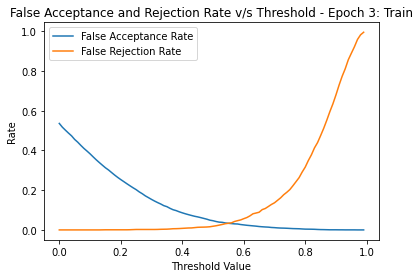

In [ ]:
plt.title("False Acceptance and Rejection Rate v/s Threshold - Epoch 3: Train")
plt.plot(threshs_train_3, fars_train_3, label="False Acceptance Rate")
plt.plot(threshs_train_3, frrs_train_3, label="False Rejection Rate")
plt.xlabel("Threshold Value")
plt.ylabel("Rate")
plt.legend()
plt.show()

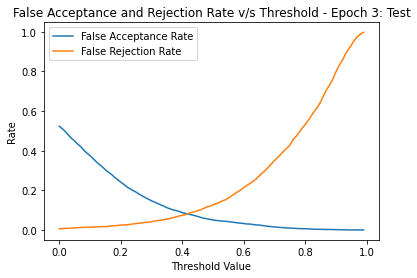

In [ ]:
plt.title("False Acceptance and Rejection Rate v/s Threshold - Epoch 3: Test")
plt.plot(threshs_test_3, fars_test_3, label="False Acceptance Rate")
plt.plot(threshs_test_3, frrs_test_3, label="False Rejection Rate")
plt.xlabel("Threshold Value")
plt.ylabel("Rate")
plt.legend()
plt.show()

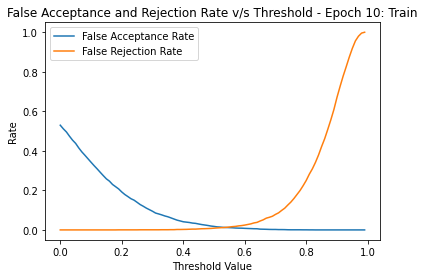

In [ ]:
plt.title("False Acceptance and Rejection Rate v/s Threshold - Epoch 10: Train")
plt.plot(threshs_train_10, fars_train_10, label="False Acceptance Rate")
plt.plot(threshs_train_10, frrs_train_10, label="False Rejection Rate")
plt.xlabel("Threshold Value")
plt.ylabel("Rate")
plt.legend()
plt.show()

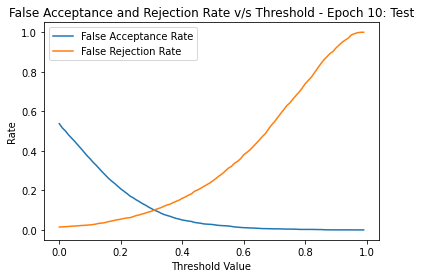

In [ ]:
plt.title("False Acceptance and Rejection Rate v/s Threshold - Epoch 10: Test")
plt.plot(threshs_test_10, fars_test_10, label="False Acceptance Rate")
plt.plot(threshs_test_10, frrs_test_10, label="False Rejection Rate")
plt.xlabel("Threshold Value")
plt.ylabel("Rate")
plt.legend()
plt.show()

In [ ]:
for epoch in range(NUM_EPOCHS):
  embedder_path = os.path.join(CHECKPT_DIR, "checkpt-embedder-{}.pt".format(epoch+1))
  lossmodule_path = os.path.join(CHECKPT_DIR, "checkpt-lossmodule-{}.pt".format(epoch+1))
  embedder.load_state_dict(torch.load(embedder_path))
  lossmodule.load_state_dict(torch.load(lossmodule_path))
  embedder.eval()
  lossmodule.eval()
  epoch_loss = 0
  print("============ Epoch {} / {} ============".format(epoch+1, NUM_EPOCHS))
  print("Testing phase")
  epoch_start = time.time()
  with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
      batch = batch.to(device)
      if step % 40 == 0 and step != 0:
        elapsed = format_time(time.time() - epoch_start)
        print("Batch {} of {}. Elapsed {}".format(step, len(test_dataloader), elapsed))
      N = batch.shape[1]
      M = batch.shape[2]
      embedder_in = batch.reshape(BATCH_SIZE*N*M, batch.shape[3], batch.shape[4])
      embeddings = embedder(embedder_in)
      embeddings = embeddings.reshape(BATCH_SIZE, N, M, n_projection)
      loss = lossmodule(embeddings)
      epoch_loss += loss.detach()
  epoch_loss /= BATCH_SIZE * len(test_dataloader)
  print("Epoch finished. Average test loss: {}".format(epoch_loss))

============ Epoch 1 / 10 ============
Testing phase
Batch 40 of 500. Elapsed 0:00:30
Batch 80 of 500. Elapsed 0:01:01
Batch 120 of 500. Elapsed 0:01:32
Batch 160 of 500. Elapsed 0:02:02
Batch 200 of 500. Elapsed 0:02:33
Batch 240 of 500. Elapsed 0:03:03
Batch 280 of 500. Elapsed 0:03:34
Batch 320 of 500. Elapsed 0:04:04
Batch 360 of 500. Elapsed 0:04:35
Batch 400 of 500. Elapsed 0:05:06
Batch 440 of 500. Elapsed 0:05:36
Batch 480 of 500. Elapsed 0:06:07
Epoch finished. Average test loss: 3.669348955154419
============ Epoch 2 / 10 ============
Testing phase
Batch 40 of 500. Elapsed 0:00:31
Batch 80 of 500. Elapsed 0:01:01
Batch 120 of 500. Elapsed 0:01:32
Batch 160 of 500. Elapsed 0:02:03
Batch 200 of 500. Elapsed 0:02:33
Batch 240 of 500. Elapsed 0:03:04
Batch 280 of 500. Elapsed 0:03:35
Batch 320 of 500. Elapsed 0:04:06
Batch 360 of 500. Elapsed 0:04:36
Batch 400 of 500. Elapsed 0:05:07
Batch 440 of 500. Elapsed 0:05:37
Batch 480 of 500. Elapsed 0:06:08
Epoch finished. Average test 

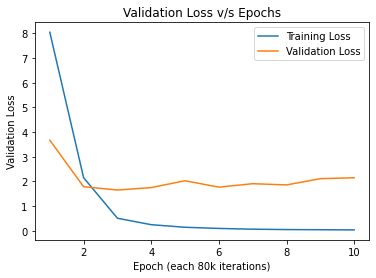

In [ ]:
# Training was done across multiple sessions, so the loss values had to be manually noted (saving and restoring was
# possible but cumbersome)
train_loss = [8.047670364379883,  2.1487631797790527, 0.5052888989448547, 0.2430151402950287, 0.1387273371219635, \
  0.09182605892419815, 0.06090567633509636, 0.0455281063914299, 0.03941136971116066, 0.03146157041192055]
plt.plot(list(range(1,11)), train_loss, label="Training Loss")
plt.xlabel("Epoch (each 80k iterations)")
plt.ylabel("Training Loss")
plt.title("Training Loss v/s Epochs")
val_loss = [3.669348955154419, 1.7841287851333618, 1.6483731269836426, 1.7482861280441284, 2.025535821914673, \
  1.7660025358200073, 1.9058339595794678, 1.8559544086456299, 2.1089377403259277, 2.1481235027313232]
plt.plot(list(range(1,11)), val_loss, label="Validation Loss")
plt.xlabel("Epoch (each 80k iterations)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss v/s Epochs")
plt.legend()
plt.show()